# State Autoencoder

This notebook trains a Transformer autoencoder to reconstruct measurements. It projects the sequential input down to a latent variable, $z$, that should represent the state of the system.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
import data.datautil as du

from models import TransformerEncoder, TransformerDecoder

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loading the data

In [3]:
data_name='Rectifier_nov23_4steps_perform3'
sim_name='RectifierData_step10h' 
dataset_name='RUL_real'

In [4]:
with open(f'./data/{data_name}/dataset_{dataset_name}_train.pkl', 'rb') as file:
    train_dataset = pickle.load(file)

In [5]:
print(f'Dataset name: {train_dataset.dataset_name}') 
for var in train_dataset.n_var:
    if train_dataset.n_var[var]:
        print(f'Features ({var}): {train_dataset.labels[var]}')  
        print(f'-shape: {train_dataset.var[var].shape}')

if train_dataset.n_var['U']:
    simulation_size=train_dataset.origin['U'].shape[1]
    print(f'Simulation size: {simulation_size}') 
print(f'Number of systems: {train_dataset.n_sys}') 

Dataset name: RUL_real
Features (X): ['i1', 'i2', 'i3', 'I_DC', 'R']
-shape: (63588, 5)
Features (Y): ['RUL']
-shape: (63588, 1)
Number of systems: 200


In [6]:
batch_size = 128
stats = ['X']
timestep=9
window={'X':[timestep,0],'Y':[0,0]}
trainloader = du.create_loader(train_dataset, batch_size, stats, window=window, shuffle=True)
trainloader

In [7]:
ex_X, ex_y = next(iter(trainloader))
print(f"X Shape: {ex_X.shape}, Y Shape: {ex_y.shape}")

X Shape: torch.Size([128, 10, 5]), Y Shape: torch.Size([128, 1, 1])


In [8]:
ex_X.dtype

torch.float64

In [9]:
enc = TransformerEncoder(input_dim=ex_X.shape[2]*ex_X.shape[1], embed_dim=2, dropout=0.1)
dec = TransformerDecoder(output_dim=ex_X.shape[2], embed_dim=2, dropout=0.1)

In [10]:
pred = enc(ex_X.to(torch.float32))

In [11]:
xhat = dec(pred)

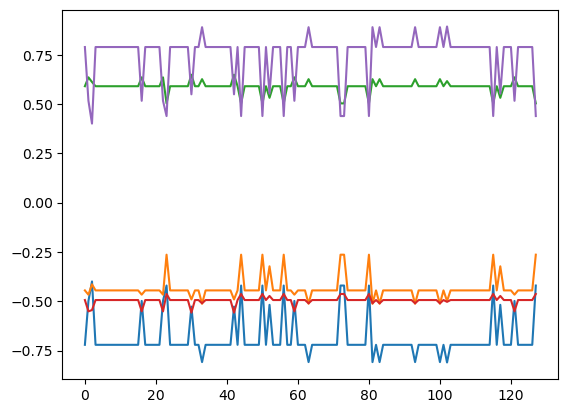

In [12]:
plt.plot(xhat.detach().numpy())

In [25]:
enc = TransformerEncoder(input_dim=ex_X.shape[2]*ex_X.shape[1], embed_dim=2, dropout=0.1, device=device).to(device)
dec = TransformerDecoder(output_dim=ex_X.shape[2], embed_dim=2, dropout=0.1).to(device)
objective = nn.MSELoss()
params = list(enc.parameters()) + list(dec.parameters())
    # optimizer
optim = torch.optim.Adam(params, lr=1e-4)

n_epochs = 25
losses = []
for i in tqdm(range(n_epochs)):
    for X, y in trainloader:
        X = X.to(torch.float32).to(device)
        y = y.to(device)
        
        z = enc(X)
        Xhat = dec(z)
        
        optim.zero_grad()     
        # print(Xhat.shape, X.shape)
        loss = objective(Xhat, X[:,-1,:])
        loss.backward()
        optim.step()
        
        losses.append(loss.item())
        
    print(f"Epoch: {i+1}, loss: {np.mean(losses[-100:])}")

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:08<03:18,  8.26s/it]

Epoch: 1, loss: 0.37150849133729935


  8%|▊         | 2/25 [00:16<03:11,  8.31s/it]

Epoch: 2, loss: 0.28613347485661506


 12%|█▏        | 3/25 [00:25<03:05,  8.41s/it]

Epoch: 3, loss: 0.22182327076792718


 16%|█▌        | 4/25 [00:33<02:55,  8.35s/it]

Epoch: 4, loss: 0.17465713262557983


 20%|██        | 5/25 [00:41<02:46,  8.32s/it]

Epoch: 5, loss: 0.138786484003067


 24%|██▍       | 6/25 [00:49<02:35,  8.21s/it]

Epoch: 6, loss: 0.11550284266471862


 28%|██▊       | 7/25 [00:57<02:27,  8.19s/it]

Epoch: 7, loss: 0.09721103884279728


 32%|███▏      | 8/25 [01:06<02:19,  8.20s/it]

Epoch: 8, loss: 0.08997238531708718


 36%|███▌      | 9/25 [01:14<02:11,  8.24s/it]

Epoch: 9, loss: 0.08228859309107066


 40%|████      | 10/25 [01:22<02:01,  8.11s/it]

Epoch: 10, loss: 0.07952086836099624


 44%|████▍     | 11/25 [01:30<01:54,  8.17s/it]

Epoch: 11, loss: 0.07698532473295927


 48%|████▊     | 12/25 [01:38<01:46,  8.23s/it]

Epoch: 12, loss: 0.0745845977216959


 52%|█████▏    | 13/25 [01:47<01:38,  8.23s/it]

Epoch: 13, loss: 0.07403522565960884


 56%|█████▌    | 14/25 [01:55<01:30,  8.27s/it]

Epoch: 14, loss: 0.07309824649244547


 60%|██████    | 15/25 [02:03<01:22,  8.25s/it]

Epoch: 15, loss: 0.07202201575040817


 64%|██████▍   | 16/25 [02:11<01:14,  8.25s/it]

Epoch: 16, loss: 0.06959357082843781


 68%|██████▊   | 17/25 [02:20<01:06,  8.25s/it]

Epoch: 17, loss: 0.07043414838612079


 72%|███████▏  | 18/25 [02:28<00:57,  8.26s/it]

Epoch: 18, loss: 0.06935363609343767


 76%|███████▌  | 19/25 [02:36<00:49,  8.30s/it]

Epoch: 19, loss: 0.06758884560316801


 80%|████████  | 20/25 [02:45<00:41,  8.28s/it]

Epoch: 20, loss: 0.06779577665030956


 84%|████████▍ | 21/25 [02:53<00:33,  8.27s/it]

Epoch: 21, loss: 0.06684183802455664


 88%|████████▊ | 22/25 [03:01<00:24,  8.26s/it]

Epoch: 22, loss: 0.06591021884232759


 92%|█████████▏| 23/25 [03:09<00:16,  8.27s/it]

Epoch: 23, loss: 0.0655197224393487


 96%|█████████▌| 24/25 [03:18<00:08,  8.27s/it]

Epoch: 24, loss: 0.06455548405647278


100%|██████████| 25/25 [03:26<00:00,  8.26s/it]

Epoch: 25, loss: 0.06469308048486709


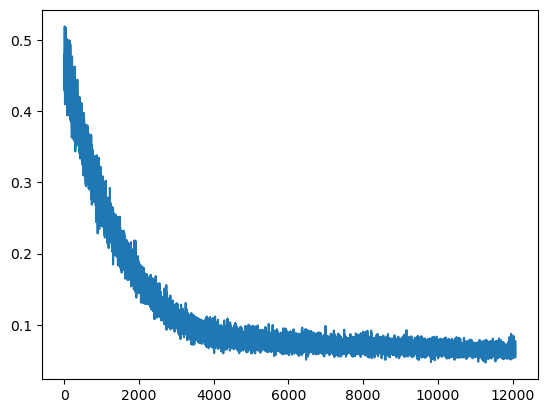

In [26]:
plt.plot(losses)

In [ ]:
pred = enc(ex_X.to(torch.float32).to(device))
xhat = dec(pred)